<a href="https://colab.research.google.com/github/Michele-Simeone/AILabProj-NBAPrediction/blob/main/CNN_NBA_SportsVu_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import numpy as np
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import IFrame
import json


!pip install pydub
from google.colab import drive
import os
from pydub import AudioSegment
from pydub.utils import make_chunks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Convertire I Dati Json in un Dataset

In [ ]:
def open_file(s,role):
  with open(s,'r') as f:
      data = json.loads(f.read())
  headers = ["team_id", "player_id", "x_loc", "y_loc", 
            "radius", "moment", "game_clock", "shot_clock","event_id"]
  df = pd.json_normalize(data, record_path =['events','moments'], meta=[["events",'eventId']])
  moments = df.values.tolist()
  player_moments = []
  i=0
  for moment in moments:
      # Formattazione dei momenti con aggiunta di informazioni temporali
      for player in moment[5]:
          player.append(i)
          player.append(moment[2])
          player.append(moment[3])
          player.append(moment[6])
          player_moments.append(player)
      i=i+1
  df = pd.DataFrame(player_moments, columns=headers)
  df["event_id"] = pd.to_numeric(df["event_id"])   
  result = pd.merge(df,role,on='player_id')
  result.sort_values(by=["moment"], inplace = True)
  result=result[["event_id","moment","player_id","name","surname","x_loc","y_loc","radius","game_clock","shot_clock","team","pg%","sg%","sf%","pf%","c%"]]
  return result

Assegnazione ruoli per evento

In [ ]:
def assign_role(a):
  b=pd.DataFrame(columns=["event_id","moment","player_id","name","surname","x_loc","y_loc","radius","game_clock","shot_clock","team","pg%","sg%","sf%","pf%","c%"])
  c=pd.DataFrame(columns=["player_id","role"])
  c=c.append({'player_id': -1,"role": "ball"},ignore_index=True)
  for i in range(1,6):
    b=b.append(a.iloc[i])
  b=b[["player_id","pg%","sg%","sf%","pf%","c%"]]
  pg=0
  x=0
  sg=0
  y=0
  sf=0
  pf=0
  m=0
  ce=0
  n=0
  for i in b.index: 
    if b["c%"][i]>=n:
      ce=b["player_id"][i]
      n=b["c%"][i]
  for i in b.index: 
    if b["pg%"][i]>=x and ce!=b["player_id"][i]:
      pg=b["player_id"][i]
      x=b["pg%"][i]
  for i in b.index: 
    if b["pf%"][i]>=m and ce!=b["player_id"][i] and pg!=b["player_id"][i]:
      pf=b["player_id"][i]
      m=b["pf%"][i]
  for i in b.index: 
    if b["sg%"][i]>=y and ce!=b["player_id"][i] and pg!=b["player_id"][i] and pf!=b["player_id"][i]:
      sg=b["player_id"][i]
      y=b["sg%"][i]
  for i in b.index: 
    if ce!=b["player_id"][i] and pg!=b["player_id"][i] and pf!=b["player_id"][i] and sg!=b["player_id"][i]:
      sf=b["player_id"][i]
      break
  c=c.append({'player_id':pg,"role": "pg"},ignore_index=True)
  c=c.append({'player_id':sg,"role": "sg"},ignore_index=True)  
  c=c.append({'player_id':sf,"role": "sf"},ignore_index=True)
  c=c.append({'player_id':pf,"role": "pf"},ignore_index=True)
  c=c.append({'player_id':ce,"role": "c"},ignore_index=True)
  return c

Plot campo

In [ ]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color="gray", lw=1, zorder=0):
    
    if ax is None:
        ax = plt.gca()


    outer = Rectangle((0,-50), width=94, height=50, color=color,
                      zorder=zorder, fill=False, lw=lw)

   
    l_hoop = Circle((5.35,-25), radius=.75, lw=lw, fill=False, 
                    color=color, zorder=zorder)
    r_hoop = Circle((88.65,-25), radius=.75, lw=lw, fill=False,
                    color=color, zorder=zorder)
    
    l_backboard = Rectangle((4,-28), 0, 6, lw=lw, color=color,
                            zorder=zorder)
    r_backboard = Rectangle((90, -28), 0, 6, lw=lw,color=color,
                            zorder=zorder)

   
    l_outer_box = Rectangle((0, -33), 19, 16, lw=lw, fill=False,
                            color=color, zorder=zorder)    
    l_inner_box = Rectangle((0, -31), 19, 12, lw=lw, fill=False,
                            color=color, zorder=zorder)
    r_outer_box = Rectangle((75, -33), 19, 16, lw=lw, fill=False,
                            color=color, zorder=zorder)

    r_inner_box = Rectangle((75, -31), 19, 12, lw=lw, fill=False,
                            color=color, zorder=zorder)

    
    l_free_throw = Circle((19,-25), radius=6, lw=lw, fill=False,
                          color=color, zorder=zorder)
    r_free_throw = Circle((75, -25), radius=6, lw=lw, fill=False,
                          color=color, zorder=zorder)

   
    l_corner_a = Rectangle((0,-3), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    l_corner_b = Rectangle((0,-47), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    r_corner_a = Rectangle((80, -3), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    r_corner_b = Rectangle((80, -47), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    
   
    l_arc = Arc((5,-25), 47.5, 47.5, theta1=292, theta2=68, lw=lw,
                color=color, zorder=zorder)
    r_arc = Arc((89, -25), 47.5, 47.5, theta1=112, theta2=248, lw=lw,
                color=color, zorder=zorder)

   
    half_court = Rectangle((47,-50), 0, 50, lw=lw, color=color,
                           zorder=zorder)

    hc_big_circle = Circle((47, -25), radius=6, lw=lw, fill=False,
                           color=color, zorder=zorder)
    hc_sm_circle = Circle((47, -25), radius=2, lw=lw, fill=False,
                          color=color, zorder=zorder)

    court_elements = [l_hoop, l_backboard, l_outer_box, outer,
                      l_inner_box, l_free_throw, l_corner_a,
                      l_corner_b, l_arc, r_hoop, r_backboard, 
                      r_outer_box, r_inner_box, r_free_throw,
                      r_corner_a, r_corner_b, r_arc, half_court,
                      hc_big_circle, hc_sm_circle]

   
    for element in court_elements:
        ax.add_patch(element)
    ax.set_facecolor('black')
    return ax

Disegnare Traiettorie Evento divise per Momenti

In [ ]:
def marracash(a,events,j,k):
     for i in range(0, a.shape[0], 444):

      dfi=a.iloc[i:i+444]
      pg=dfi[dfi.role=='pg']
      sg=dfi[dfi.role=='sg']
      sf=dfi[dfi.role=='sf']
      pf=dfi[dfi.role=='pf']
      ce=dfi[dfi.role=='c']
      ball=dfi[dfi.role=='ball']

      plt.figure(figsize=(15, 11.5))
      plt.scatter(pg.x_loc, -pg.y_loc, c=pg.game_clock,cmap=plt.cm.Blues_r, s=50, zorder=5)
      plt.scatter(sg.x_loc, -sg.y_loc, c=sg.game_clock, cmap=plt.cm.Oranges_r, s=50, zorder=1)
      plt.scatter(sf.x_loc, -sf.y_loc, c=sf.game_clock,cmap=plt.cm.RdPu_r, s=50, zorder=4)
      plt.scatter(pf.x_loc, -pf.y_loc, c=pf.game_clock,cmap=plt.cm.Purples_r, s=50, zorder=2)
      plt.scatter(ce.x_loc, -ce.y_loc, c=ce.game_clock,cmap=plt.cm.Greens_r, s=50, zorder=3)
      plt.scatter(ball.x_loc, -ball.y_loc, c=ball.game_clock,cmap=plt.cm.Reds_r, s=50, zorder=6)
    

      draw_court()

      plt.xlim(0, 101)
      plt.ylim(-50, 0)
      plt.yticks([])
      plt.xticks([])
      plt.savefig("/content/drive/MyDrive/LabIA/Images/Boston/"+str(k)+'/'+str(events["event_id"][j])+'/'+str(i)+'.png', bbox_inches = 'tight')
      plt.close()
      

In [ ]:
def tedua(k,role):
  result=open_file('/content/drive/MyDrive/LabIA/Data/Traiettorie/Boston/1 ('+str(k)+').json',role)
  try:
      os.mkdir("/content/drive/MyDrive/LabIA/Images/Boston/"+str(k))
  except:
      print("Folder already found")
  events=result.groupby("event_id",as_index=False)["moment"].count()
  events=events[events.moment>=3828]
  events=events[["event_id"]]
  result = pd.merge(result,events,on='event_id')
  result.sort_values(by=["moment","player_id"], inplace = True)
  for j in events.index: 
     a=result[result.event_id==events["event_id"][j]]
     c=assign_role(a)
     a = pd.merge(a,c,on='player_id')
     a.drop(['pg%', 'sg%','sf%','pf%','c%'], axis = 1,inplace=True)
     a.sort_values(by=["moment","player_id"], inplace = True)
     try:
      os.mkdir("/content/drive/MyDrive/LabIA/Images/Boston/"+str(k)+'/'+str(events["event_id"][j]))
     except:
      print("Folder already found")
     marracash(a,events,j,k)

In [ ]:

headers = ["player_id", "name", "surname", 
           "team", "pg%", "sg%", "sf%","pf%","c%"]
role=pd.read_csv(r'/content/drive/MyDrive/LabIA/Data/Ruoli Giocatori/NBA_Player_Role_2016 Query.csv',sep=';')
role.columns=headers
role=role[role.team=="BOS"]
role=role.append({"player_id":-1,"name":"Ball","surname":None,"team":None,"pg%":-1,"sg%":-1,"sf%":-1,"pf%":-1,"c%":-1}, ignore_index=True)
role.sort_values(by=["player_id"], inplace = True)
tedua(42,role)

In [ ]:
for u in range(3,43):
  try:
      os.mkdir("/content/drive/MyDrive/LabIA/Images/Boston/3/Indy Rip 14/L/"+str(u))
      os.mkdir("/content/drive/MyDrive/LabIA/Images/Boston/3/Indy Rip 14/R/"+str(u))
      os.mkdir("/content/drive/MyDrive/LabIA/Images/Boston/3/Zip Chase/L/"+str(u))
      os.mkdir("/content/drive/MyDrive/LabIA/Images/Boston/3/Zip Chase/R/"+str(u))
  except:
      print("Folder already found")
  

NumPy: Flip Images

In [ ]:

def image_flip(a,s):
  im = Image.open(a)
  numpydata = np.asarray(im)
  numpydata=np.flip(numpydata,0)
  numpydata=np.flip(numpydata,1)
  #noise = np.random.normal(0, .1, numpydata.shape)
  #numpydata = numpydata + noise
  pilImage = Image.fromarray(numpydata)
  pilImage.save(s)


In [ ]:
i=1
for file in os.listdir('/content/drive/MyDrive/LabIA/Dataset/Temporaneo/CNN/ 0 Zip Chase/R'):
    b='/content/drive/MyDrive/LabIA/Dataset/Temporaneo/CNN/ 0 Zip Chase/R/'+file
    s='/content/drive/MyDrive/LabIA/Dataset/Temporaneo/CNN/ 0 Zip Chase/L/'+str(i)+".png"
    image_flip(b,s)
    i=i+1
    

Data Augmentation

In [ ]:
def image_hor(a,s):
  im = Image.open(a)
  numpydata = np.asarray(im)
  numpydata=np.flip(numpydata,1)
  #noise = np.random.normal(0, .1, numpydata.shape)
  #numpydata = numpydata + noise
  pilImage = Image.fromarray(numpydata)
  pilImage.save(s)

def image_ver(a,s,c,d):
  im1 = Image.open(a)
  im2 = Image.open(s)
  numpydata1 = np.asarray(im1)
  numpydata2 = np.asarray(im2)
  numpydata1=np.flip(numpydata1,0)
  numpydata2=np.flip(numpydata2,0)
  #noise = np.random.normal(0, .1, numpydata.shape)
  #numpydata = numpydata + noise
  pilImage1 = Image.fromarray(numpydata1)
  pilImage2 = Image.fromarray(numpydata2)
  pilImage1.save(c)
  pilImage2.save(d)

In [ ]:
i=1999
for file in os.listdir('/content/drive/MyDrive/LabIA/Dataset/CNN/Test/Zip Chase'):
    b='/content/drive/MyDrive/LabIA/Dataset/CNN/Test/Zip Chase/'+file
    s='/content/drive/MyDrive/LabIA/Dataset/CNN/Test/A/'+str(i)+".png"
    f='/content/drive/MyDrive/LabIA/Dataset/CNN/Test/A/'+str(i+1)+".png"
    g='/content/drive/MyDrive/LabIA/Dataset/CNN/Test/A/'+str(i+2)+".png"
    image_hor(b,s)
    image_ver(b,s,f,g)
    i=i+3
    

Rete Neurale

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# 256x256 per i pixels dell'immagine, and 3 per i canali
img_input = layers.Input(shape=(256, 256, 3))

# Estrazione di 16 filtri 3x3, poi Max-Pool con una finestra 2x2
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Estrazione di 32 filtri 3x3,  poi Max-Pool con una finestra 2x2
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Estrazione di 64 filtri 3x3,  poi Max-Pool con una finestra 2x2
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten della feature map a un tensore ad una dim così creiamo un full-connected layer
x = layers.Flatten()(x)

# Creazione di un fully-connected layer con ReLU e 512 unità hidden 
x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

# Creazione di un layer output con sigmoide
output = layers.Dense(1, activation='sigmoid')(x)


model = Model(img_input, output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496 

In [2]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir="/content/drive/MyDrive/LabIA/Dataset/CNN/Train"
test_dir="/content/drive/MyDrive/LabIA/Dataset/CNN/Test"

train_datagen = ImageDataGenerator(rescale=1./255,
                validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(256, 256),  
        batch_size=16,
        class_mode='binary',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=16,
        class_mode='binary',
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=16,
        class_mode='binary')



Found 606 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [4]:
history = model.fit(
      train_generator,
      steps_per_epoch=30,  
      epochs=5,
      validation_data=validation_generator,
      validation_steps=8, 
      verbose=2)

Epoch 1/5
30/30 - 13s - loss: 0.9164 - acc: 0.5271 - val_loss: 0.7297 - val_acc: 0.5234 - 13s/epoch - 431ms/step
Epoch 2/5
30/30 - 10s - loss: 0.5671 - acc: 0.7125 - val_loss: 1.1136 - val_acc: 0.5312 - 10s/epoch - 331ms/step
Epoch 3/5
30/30 - 8s - loss: 0.3370 - acc: 0.8729 - val_loss: 0.4947 - val_acc: 0.7188 - 8s/epoch - 275ms/step
Epoch 4/5
30/30 - 10s - loss: 0.1272 - acc: 0.9603 - val_loss: 0.3246 - val_acc: 0.8594 - 10s/epoch - 349ms/step
Epoch 5/5
30/30 - 7s - loss: 0.0559 - acc: 0.9874 - val_loss: 0.3304 - val_acc: 0.8438 - 7s/epoch - 249ms/step


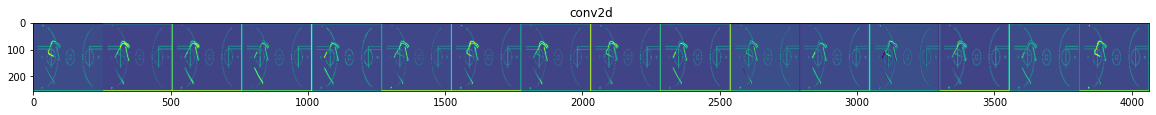

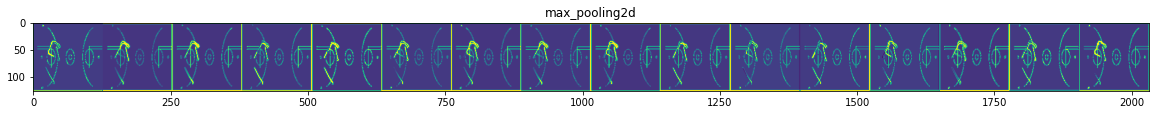

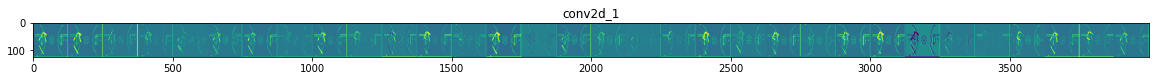

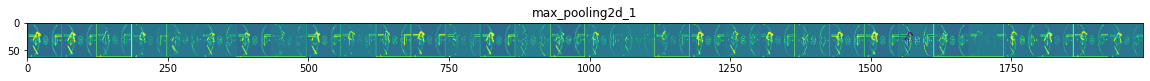

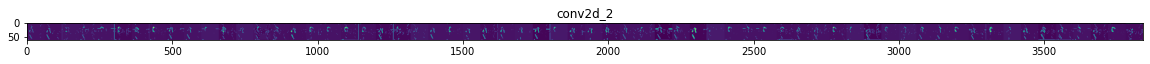

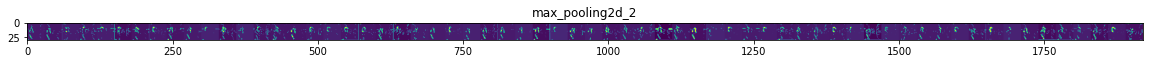

In [5]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)


img_path =  "/content/drive/MyDrive/LabIA/Dataset/CNN/Train/Indy Rip/12.png"

img = load_img(img_path, target_size=(256, 256))  
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  


x /= 255


successive_feature_maps = visualization_model.predict(x)


layer_names = [layer.name for layer in model.layers[1:]]


for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1] 
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training and validation loss')

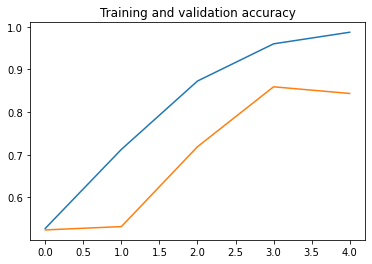

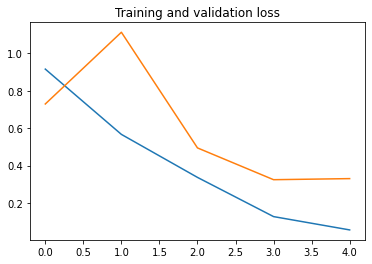

In [6]:

acc = history.history['acc']
val_acc = history.history['val_acc']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()


plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [17]:
results = model.evaluate(
      test_generator,
      batch_size=16)
print("test loss, test acc:", results)


16/16 [==============================] - 5s 287ms/step - loss: 0.4705 - acc: 0.8750
test loss, test acc: [0.47053617238998413, 0.875]


In [18]:
def plots(ims, figsize=(256,256), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=32)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


In [19]:
import pandas as pd

def to_label(value):
    if value==0:
        return 'Zip Chase'
    else:
        return 'Indy Rip'


test_imgs, test_labels = next(test_generator)
predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:]
df['predicted'] = np.round(predictions[:,0])
df['predicted_labels']=df['predicted'].map(lambda x: to_label(x))
plots(test_imgs, titles=df['predicted_labels'])

